In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.preprocessing.image import array_to_img, img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import imutils
import cv2
import glob
from matplotlib import cm

Found 5385 files belonging to 9 classes.
Using 4308 files for training.
Found 5385 files belonging to 9 classes.
Using 1077 files for validation.
['high_center', 'high_left', 'high_right', 'low_center', 'low_left', 'low_right', 'middle_center', 'middle_left', 'middle_right']


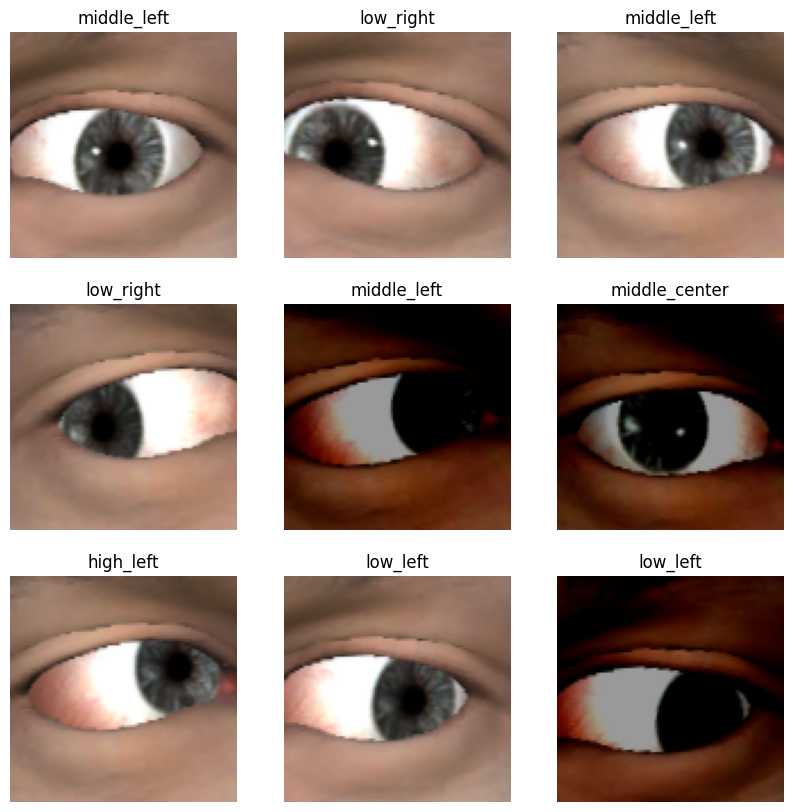

In [ ]:
train_dir = "/content/drive/MyDrive/neiro_project/train_classification/"

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=64,
                                             image_size=(100, 100),
                                             validation_split=0.2,
                                             subset="training",
                                             seed = 123
                                             )

validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=64,
                                             image_size=(100, 100),
                                             validation_split=0.2,
                                             subset="validation",
                                             seed = 123
                                             )

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
l = train_dataset.take(1)

print(class_names)

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Модель

In [ ]:
IMG_SHAPE = (100, 100) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [ ]:
base_model.trainable = False
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(9, activation = "softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(100, 100, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

In [ ]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(train_dataset)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

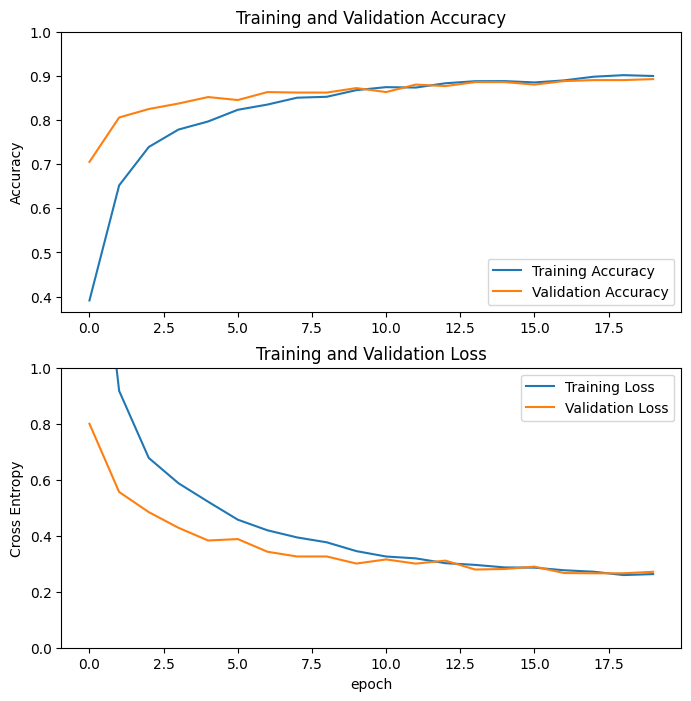

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True
fine_tune_at = 80
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 100, 100, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 100, 100, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

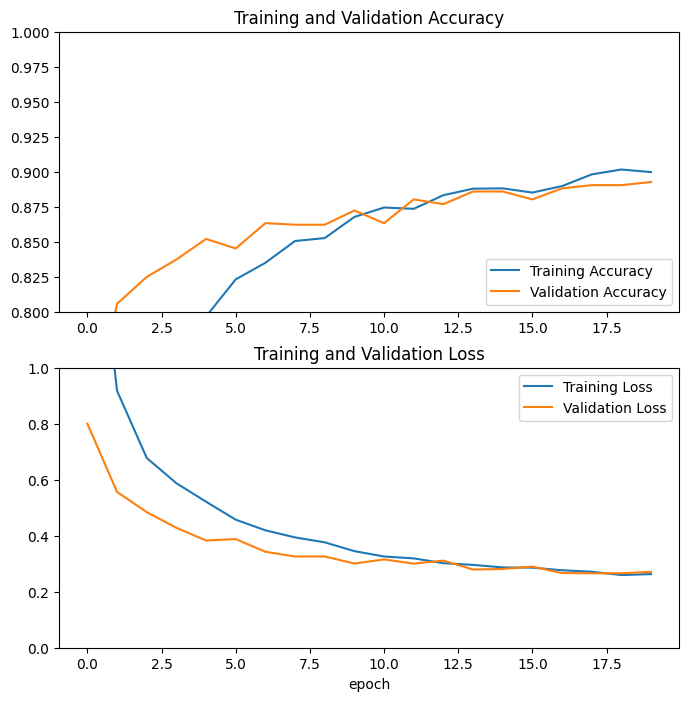

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [2 0 1 4 1 2 7 4 8 5 2 5 1 8 0 3 8 2 8 4 7 1 8 1 8 4 1 4 3 6 4 7 1 5 5 8 3
 5 2 8 5 3 7 3 7 3 2 1 2 2 8 2 2 4 4 8 1 7 3 5 4 2 2 5]
Labels:
 [2 0 1 4 1 2 7 4 8 5 2 5 1 8 0 3 2 2 8 4 7 1 8 1 8 4 1 4 3 6 4 7 1 5 5 8 3
 5 2 8 5 3 4 3 7 3 2 1 2 2 8 2 2 4 4 8 1 7 3 5 4 2 2 5]


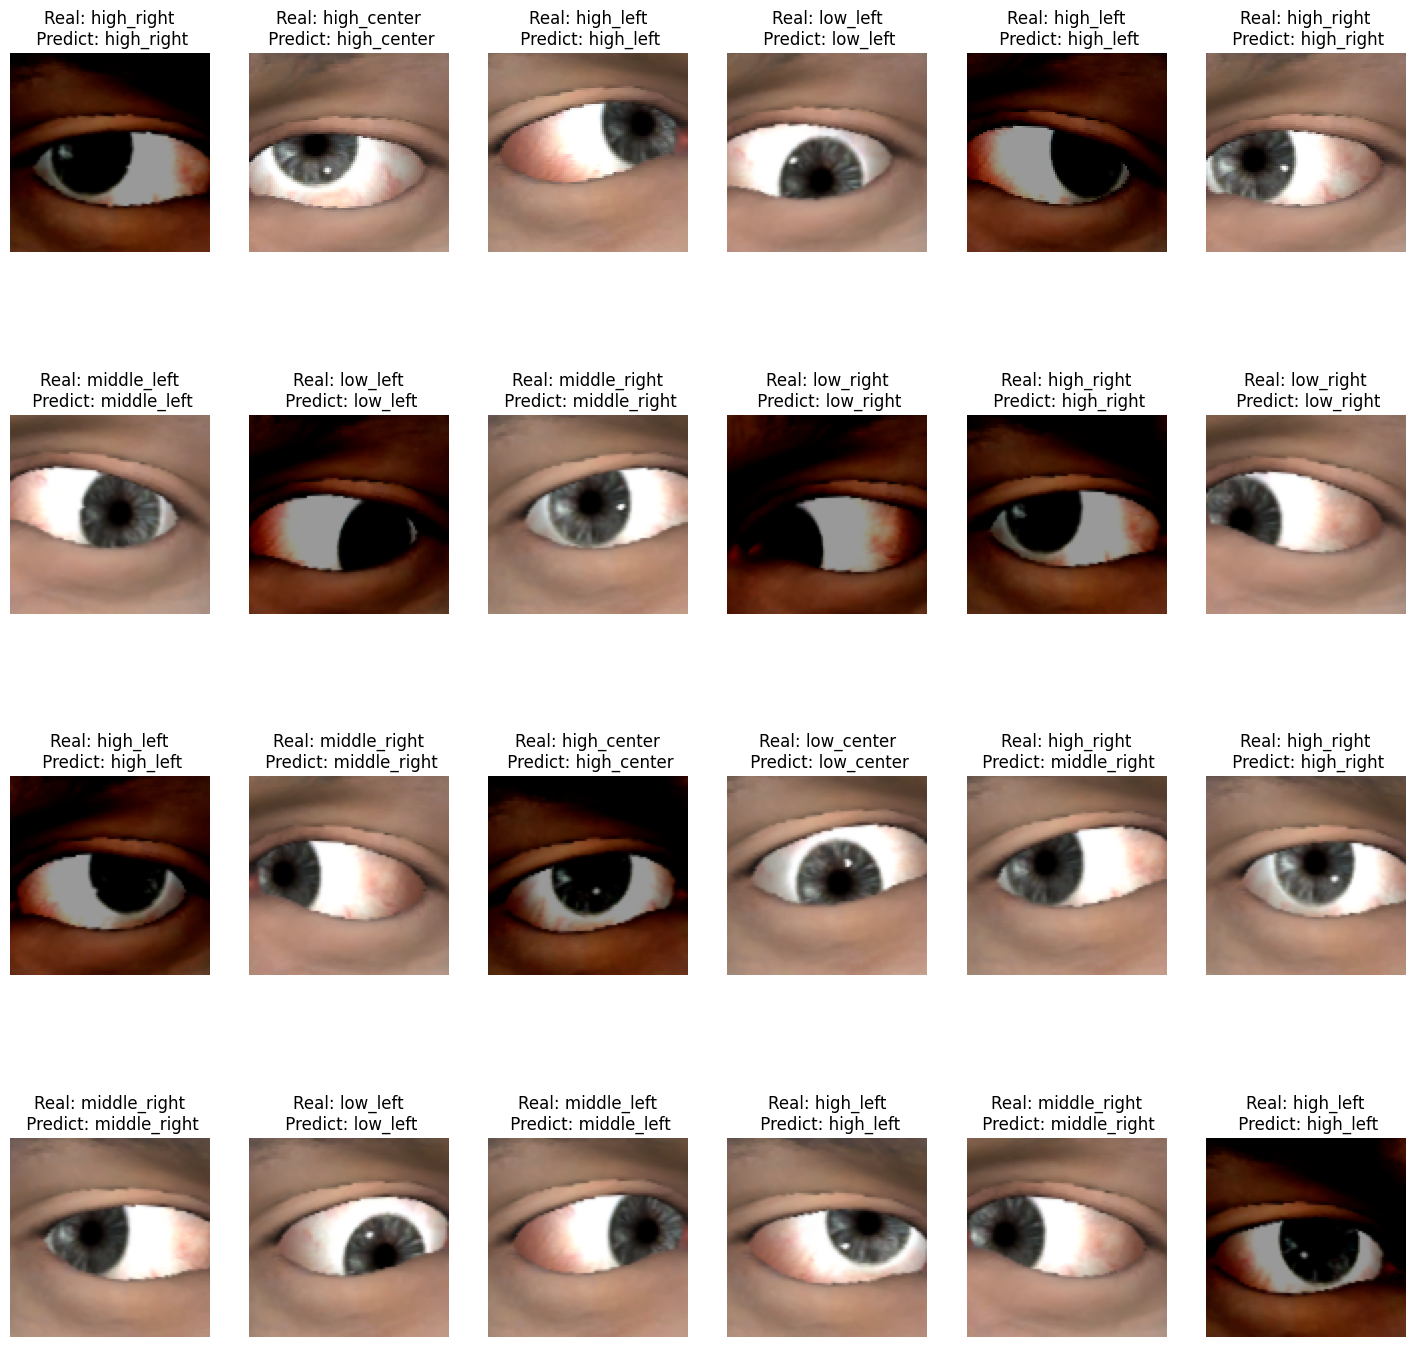

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.sigmoid(predictions).numpy()

label_predictions = np.array([])
for elem in predictions:
  label_predictions = np.append(label_predictions, np.argmax(elem))

label_predictions = label_predictions.astype(int)

print('Predictions:\n', label_predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(18, 18))
for i in range(24):
  ax = plt.subplot(4, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Real: ' + class_names[label_batch[i]] + '\n Predict: ' + class_names[label_predictions[i]])
  plt.axis("off")

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 3s 351ms/step - loss: 0.2349 - accuracy: 0.9427
Test accuracy : 0.9427083134651184


In [ ]:
model.save('/content/drive/MyDrive/neiro_project/model/eye_model')

Тест распознавания на реальных фото


In [ ]:
class_names = ['high_center', 'high_left', 'high_right', 'low_center', 'low_left', 'low_right', 'middle_center', 'middle_left', 'middle_right']
dir_img = "img11.jpg"
model = tf.keras.models.load_model('/content/drive/MyDrive/neiro_project/model/eye_model')

for i in dir_img:
  img = cv2.imread(i)
  resized = cv2.resize(img, (100,100), interpolation=cv2.INTER_CUBIC)
  img_r = np.zeros((1,resized.shape[0], resized.shape[1], 3))
  for j in range(3):
    img_r[0,:,:,j] = (resized[:,:,j])
  pred = model.predict_on_batch(img_r)
  pred = tf.nn.sigmoid(pred).numpy()
  class_predicted = np.argmax(pred[0])

  plt.figure(figsize=(3, 3))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('\n Predict: ' + class_names[class_predicted])
  plt.axis("off")

OSError: No file or directory found at ./model/eye_model